In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras import optimizers
from keras.layers import Dense, Dropout, LSTM
from keras.utils import to_categorical
from keras.models import Sequential, Model
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

# Set seeds to make the experiment more reproducible.
from tensorflow import set_random_seed
from numpy.random import seed
set_random_seed(0)
seed(0)

Using TensorFlow backend.


### Load data

In [2]:
train = pd.read_csv('../input/X_train.csv')
labels = pd.read_csv('../input/y_train.csv')
test = pd.read_csv('../input/X_test.csv').sort_values(['series_id', 'measurement_number'])

### Join train features with labels

In [3]:
train = pd.merge(train, labels, how='inner').sort_values(['series_id', 'measurement_number'])
print(train.shape)
display(train.head())
display(train.describe().T)

(487680, 15)


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,group_id,surface
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,13,fine_concrete
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,13,fine_concrete
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,13,fine_concrete
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,13,fine_concrete
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,13,fine_concrete


,count,mean,std,min,25%,50%,75%,max
series_id,487680.0,1904.500000,1099.853353,0.00000,952.000000,1904.500000,2857.000000,3809.00000
measurement_number,487680.0,63.500000,36.949327,0.00000,31.750000,63.500000,95.250000,127.00000
orientation_X,487680.0,-0.018050,0.685696,-0.98910,-0.705120,-0.105960,0.651803,0.98910
orientation_Y,487680.0,0.075062,0.708226,-0.98965,-0.688980,0.237855,0.809550,0.98898
orientation_Z,487680.0,0.012458,0.105972,-0.16283,-0.089466,0.031949,0.122870,0.15571
orientation_W,487680.0,-0.003804,0.104299,-0.15662,-0.106060,-0.018704,0.097215,0.15477
angular_velocity_X,487680.0,0.000178,0.117764,-2.37100,-0.040752,0.000084,0.040527,2.28220
angular_velocity_Y,487680.0,0.008338,0.088677,-0.92786,-0.033191,0.005412,0.048068,1.07910
angular_velocity_Z,487680.0,-0.019184,0.229153,-1.26880,-0.090743,-0.005335,0.064604,1.38730
linear_acceleration_X,487680.0,0.129281,1.870600,-36.06700,-0.530833,0.124980,0.792263,36.79700


### Turn data into series

In [4]:
def series_to_supervised(data, features, window=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data[features].shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in features]
    # Current timestep (t=0)
    cols.append(data)
    names += [(col) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

In [5]:
window = 10
features = ['angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z', 
            'linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z', 
            'series_id']
use_cols = features + ['surface']
# Train
train_series = series_to_supervised(train[use_cols], features, window=window)
train_series.dropna(inplace=True)        
train_series = train_series[(train_series['series_id'] == train_series['series_id(t-%s)' % window])]
display(train_series.head())

# Test
test_series = series_to_supervised(test[features], features, window=window)
test_series.fillna(test_series.mean(), inplace=True)
# Backwards inputation
for index, row in test_series.iterrows():
    for i in range(1, window+1):
        if row['series_id'] != row['series_id(t-%s)' % i]:
            for feature in features:
                if feature != 'series_id':
                    test_series.at[index, '%s(t-%s)' % (feature, i)] = row[feature]
display(test_series.head())

,angular_velocity_X(t-10),angular_velocity_Y(t-10),angular_velocity_Z(t-10),linear_acceleration_X(t-10),linear_acceleration_Y(t-10),linear_acceleration_Z(t-10),series_id(t-10),angular_velocity_X(t-9),angular_velocity_Y(t-9),angular_velocity_Z(t-9),linear_acceleration_X(t-9),linear_acceleration_Y(t-9),linear_acceleration_Z(t-9),series_id(t-9),angular_velocity_X(t-8),angular_velocity_Y(t-8),angular_velocity_Z(t-8),linear_acceleration_X(t-8),linear_acceleration_Y(t-8),linear_acceleration_Z(t-8),series_id(t-8),angular_velocity_X(t-7),angular_velocity_Y(t-7),angular_velocity_Z(t-7),linear_acceleration_X(t-7),linear_acceleration_Y(t-7),linear_acceleration_Z(t-7),series_id(t-7),angular_velocity_X(t-6),angular_velocity_Y(t-6),angular_velocity_Z(t-6),linear_acceleration_X(t-6),linear_acceleration_Y(t-6),linear_acceleration_Z(t-6),series_id(t-6),angular_velocity_X(t-5),angular_velocity_Y(t-5),angular_velocity_Z(t-5),linear_acceleration_X(t-5),linear_acceleration_Y(t-5),linear_acceleration_Z(t-5),series_id(t-5),angular_velocity_X(t-4),angular_velocity_Y(t-4),angular_velocity_Z(t-4),linear_acceleration_X(t-4),linear_acceleration_Y(t-4),linear_acceleration_Z(t-4),series_id(t-4),angular_velocity_X(t-3),angular_velocity_Y(t-3),angular_velocity_Z(t-3),linear_acceleration_X(t-3),linear_acceleration_Y(t-3),linear_acceleration_Z(t-3),series_id(t-3),angular_velocity_X(t-2),angular_velocity_Y(t-2),angular_velocity_Z(t-2),linear_acceleration_X(t-2),linear_acceleration_Y(t-2),linear_acceleration_Z(t-2),series_id(t-2),angular_velocity_X(t-1),angular_velocity_Y(t-1),angular_velocity_Z(t-1),linear_acceleration_X(t-1),linear_acceleration_Y(t-1),linear_acceleration_Z(t-1),series_id(t-1),angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,series_id,surface
10,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,0.0,0.067851,0.029939,0.003385,0.33995,1.50640,-9.4128,0.0,0.007275,0.028934,-0.005978,-0.26429,1.59220,-8.7267,0.0,-0.013053,0.019448,-0.008974,0.42684,1.099300,-10.0960,0.0,0.005135,0.007652,0.005245,-0.50969,1.468900,-10.4410,0.0,0.059664,0.013043,-0.013231,-0.44745,0.992810,-10.4020,0.0,0.082140,0.044356,-0.002696,-0.14163,0.734970,-9.4296,0.0,0.056218,0.038162,-0.022931,-0.12160,0.075417,-8.6088,0.0,-0.012846,0.039004,-0.007831,1.60000,0.81611,-7.6426,0.0,-0.090082,0.027299,-0.009970,0.47496,0.90960,-8.8120,0.0,-0.088418,0.011778,-0.016589,1.594300,0.37205,-11.2160,0,fine_concrete
11,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,0.0,0.007275,0.028934,-0.005978,-0.26429,1.59220,-8.7267,0.0,-0.013053,0.019448,-0.008974,0.42684,1.09930,-10.0960,0.0,0.005135,0.007652,0.005245,-0.50969,1.468900,-10.4410,0.0,0.059664,0.013043,-0.013231,-0.44745,0.992810,-10.4020,0.0,0.082140,0.044356,-0.002696,-0.14163,0.734970,-9.4296,0.0,0.056218,0.038162,-0.022931,-0.12160,0.075417,-8.6088,0.0,-0.012846,0.039004,-0.007831,1.60000,0.816110,-7.6426,0.0,-0.090082,0.027299,-0.009970,0.47496,0.90960,-8.8120,0.0,-0.088418,0.011778,-0.016589,1.59430,0.37205,-11.2160,0.0,0.000671,0.022855,-0.005791,0.936820,0.12651,-11.2730,0,fine_concrete
12,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,0.0,-0.013053,0.019448,-0.008974,0.42684,1.09930,-10.0960,0.0,0.005135,0.007652,0.005245,-0.50969,1.46890,-10.4410,0.0,0.059664,0.013043,-0.013231,-0.44745,0.992810,-10.4020,0.0,0.082140,0.044356,-0.002696,-0.14163,0.734970,-9.4296,0.0,0.056218,0.038162,-0.022931,-0.12160,0.075417,-8.6088,0.0,-0.012846,0.039004,-0.007831,1.60000,0.816110,-7.6426,0.0,-0.090082,0.027299,-0.009970,0.47496,0.909600,-8.8120,0.0,-0.088418,0.011778,-0.016589,1.59430,0.37205,-11.2160,0.0,0.000671,0.022855,-0.005791,0.93682,0.12651,-11.2730,0.0,0.040139,-0.003868,-0.030181,0.672260,0.85197,-9.3933,0,fine_concrete
13,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,0.0,0.005135,0.007652,0.005245,-0.50969,1.46890,-10.4410,0.0,0.059664,0.013043,-0.013231,-0.44745,0.99281,-10.4020,0.0,0.082140,0.044356,-0.002696,-0.14163,0.734970,-9.42

,angular_velocity_X(t-10),angular_velocity_Y(t-10),angular_velocity_Z(t-10),linear_acceleration_X(t-10),linear_acceleration_Y(t-10),linear_acceleration_Z(t-10),series_id(t-10),angular_velocity_X(t-9),angular_velocity_Y(t-9),angular_velocity_Z(t-9),linear_acceleration_X(t-9),linear_acceleration_Y(t-9),linear_acceleration_Z(t-9),series_id(t-9),angular_velocity_X(t-8),angular_velocity_Y(t-8),angular_velocity_Z(t-8),linear_acceleration_X(t-8),linear_acceleration_Y(t-8),linear_acceleration_Z(t-8),series_id(t-8),angular_velocity_X(t-7),angular_velocity_Y(t-7),angular_velocity_Z(t-7),linear_acceleration_X(t-7),linear_acceleration_Y(t-7),linear_acceleration_Z(t-7),series_id(t-7),angular_velocity_X(t-6),angular_velocity_Y(t-6),angular_velocity_Z(t-6),linear_acceleration_X(t-6),linear_acceleration_Y(t-6),linear_acceleration_Z(t-6),series_id(t-6),angular_velocity_X(t-5),angular_velocity_Y(t-5),angular_velocity_Z(t-5),linear_acceleration_X(t-5),linear_acceleration_Y(t-5),linear_acceleration_Z(t-5),series_id(t-5),angular_velocity_X(t-4),angular_velocity_Y(t-4),angular_velocity_Z(t-4),linear_acceleration_X(t-4),linear_acceleration_Y(t-4),linear_acceleration_Z(t-4),series_id(t-4),angular_velocity_X(t-3),angular_velocity_Y(t-3),angular_velocity_Z(t-3),linear_acceleration_X(t-3),linear_acceleration_Y(t-3),linear_acceleration_Z(t-3),series_id(t-3),angular_velocity_X(t-2),angular_velocity_Y(t-2),angular_velocity_Z(t-2),linear_acceleration_X(t-2),linear_acceleration_Y(t-2),linear_acceleration_Z(t-2),series_id(t-2),angular_velocity_X(t-1),angular_velocity_Y(t-1),angular_velocity_Z(t-1),linear_acceleration_X(t-1),linear_acceleration_Y(t-1),linear_acceleration_Z(t-1),series_id(t-1),angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,series_id
0,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,1907.460947,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,1907.464852,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,1907.468758,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,1907.472663,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,1907.476568,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,1907.480474,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,1907.484379,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,1907.488284,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,1907.49219,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,1907.496095,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,0
1,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,1907.460947,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,1907.464852,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,1907.468758,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,1907.472663,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,1907.476568,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,1907.480474,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,1907.484379,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,1907.488284,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,1907.49219,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,0.000000,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,0
2,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,1907.460947,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,1907.464852,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,1907.468758,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,1907.472663,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,1907.476568,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,1907.480474,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,1907.484379,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,1907.488284,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,0.00000,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,0.000000,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,0
3,0.070067,0.033820,-0.035904,0.71096,1.8582,-12.2270,1907.460947,0.07

### Pre process the labels

In [6]:
n_labels =  train_series['surface'].nunique()
labels_names = train_series['surface'].unique()
le = LabelEncoder()
train_series['surface'] = le.fit_transform(train_series['surface'].values)

### Train/validation split

In [7]:
train_splited = []
val_splited = []
gp_surface = train.groupby(['surface', 'series_id'], as_index=False).count()[['surface', 'series_id']]
for surface in gp_surface['surface'].unique():
    df = gp_surface[gp_surface['surface'] == surface]
    tra, val = train_test_split(df, test_size=0.2, random_state=0)
    train_splited += list(tra['series_id'].values)
    val_splited += list(val['series_id'].values)
    
train_splited = pd.DataFrame(train_splited, columns=['series_id'])
val_splited = pd.DataFrame(val_splited, columns=['series_id'])

In [8]:
X_train = train_splited.merge(train_series)
X_val = val_splited.merge(train_series)

Y_train = X_train['surface']
Y_train = to_categorical(Y_train)
X_train.drop('surface', axis=1, inplace=True)
X_train = X_train

Y_val = X_val['surface']
Y_val = to_categorical(Y_val)
X_val.drop('surface', axis=1, inplace=True)
X_val = X_val

series_cols = list(X_train.filter(regex='series_id'))
X_train.drop(series_cols, axis=1, inplace=True)
X_val.drop(series_cols, axis=1, inplace=True)
test_series.drop(series_cols, axis=1, inplace=True)

print('Train shape', X_train.shape)
print('Validation shape', X_val.shape)
display(X_train.head())

Train shape (359192, 66)
Validation shape (90388, 66)


,angular_velocity_X(t-10),angular_velocity_Y(t-10),angular_velocity_Z(t-10),linear_acceleration_X(t-10),linear_acceleration_Y(t-10),linear_acceleration_Z(t-10),angular_velocity_X(t-9),angular_velocity_Y(t-9),angular_velocity_Z(t-9),linear_acceleration_X(t-9),linear_acceleration_Y(t-9),linear_acceleration_Z(t-9),angular_velocity_X(t-8),angular_velocity_Y(t-8),angular_velocity_Z(t-8),linear_acceleration_X(t-8),linear_acceleration_Y(t-8),linear_acceleration_Z(t-8),angular_velocity_X(t-7),angular_velocity_Y(t-7),angular_velocity_Z(t-7),linear_acceleration_X(t-7),linear_acceleration_Y(t-7),linear_acceleration_Z(t-7),angular_velocity_X(t-6),angular_velocity_Y(t-6),angular_velocity_Z(t-6),linear_acceleration_X(t-6),linear_acceleration_Y(t-6),linear_acceleration_Z(t-6),angular_velocity_X(t-5),angular_velocity_Y(t-5),angular_velocity_Z(t-5),linear_acceleration_X(t-5),linear_acceleration_Y(t-5),linear_acceleration_Z(t-5),angular_velocity_X(t-4),angular_velocity_Y(t-4),angular_velocity_Z(t-4),linear_acceleration_X(t-4),linear_acceleration_Y(t-4),linear_acceleration_Z(t-4),angular_velocity_X(t-3),angular_velocity_Y(t-3),angular_velocity_Z(t-3),linear_acceleration_X(t-3),linear_acceleration_Y(t-3),linear_acceleration_Z(t-3),angular_velocity_X(t-2),angular_velocity_Y(t-2),angular_velocity_Z(t-2),linear_acceleration_X(t-2),linear_acceleration_Y(t-2),linear_acceleration_Z(t-2),angular_velocity_X(t-1),angular_velocity_Y(t-1),angular_velocity_Z(t-1),linear_acceleration_X(t-1),linear_acceleration_Y(t-1),linear_acceleration_Z(t-1),angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0.028959,-0.011703,0.026238,0.032400,4.1378,-8.8985,0.014238,-0.015342,0.030203,0.422020,3.7190,-9.1178,0.017162,-0.026594,0.038941,0.074069,3.3176,-9.4564,0.035360,-0.032865,0.037684,0.16020,3.9802,-9.1033,0.028209,-0.006577,0.039904,0.09113,3.9570,-9.1022,0.023578,-0.013967,0.033559,-0.42657,4.0422,-9.0786,0.034825,-0.020897,0.042671,0.139720,3.6555,-9.5355,0.060540,-0.014815,0.045493,-0.531250,3.1171,-9.6271,0.065362,-0.005506,0.040376,0.143380,3.3331,-9.2001,0.050770,-0.008735,0.042182,-0.250850,3.4112,-8.6230,0.026247,-0.017086,0.040887,-0.054856,3.2816,-8.8680
1,0.014238,-0.015342,0.030203,0.422020,3.7190,-9.1178,0.017162,-0.026594,0.038941,0.074069,3.3176,-9.4564,0.035360,-0.032865,0.037684,0.160200,3.9802,-9.1033,0.028209,-0.006577,0.039904,0.09113,3.9570,-9.1022,0.023578,-0.013967,0.033559,-0.42657,4.0422,-9.0786,0.034825,-0.020897,0.042671,0.13972,3.6555,-9.5355,0.060540,-0.014815,0.045493,-0.531250,3.1171,-9.6271,0.065362,-0.005506,0.040376,0.143380,3.3331,-9.2001,0.050770,-0.008735,0.042182,-0.250850,3.4112,-8.6230,0.026247,-0.017086,0.040887,-0.054856,3.2816,-8.8680,0.028200,-0.011906,0.052096,0.043050,2.6516,-9.8701
2,0.017162,-0.026594,0.038941,0.074069,3.3176,-9.4564,0.035360,-0.032865,0.037684,0.160200,3.9802,-9.1033,0.028209,-0.006577,0.039904,0.091130,3.9570,-9.1022,0.023578,-0.013967,0.033559,-0.42657,4.0422,-9.0786,0.034825,-0.020897,0.042671,0.13972,3.6555,-9.5355,0.060540,-0.014815,0.045493,-0.53125,3.1171,-9.6271,0.065362,-0.005506,0.040376,0.143380,3.3331,-9.2001,0.050770,-0.008735,0.042182,-0.250850,3.4112,-8.6230,0.026247,-0.017086,0.040887,-0.054856,3.2816,-8.8680,0.028200,-0.011906,0.052096,0.043050,2.6516,-9.8701,0.048424,-0.014165,0.043623,-0.516440,2.6113,-10.0330
3,0.035360,-0.032865,0.037684,0.160200,3.9802,-9.1033,0.028209,-0.006577,0.039904,0.091130,3.9570,-9.1022,0.023578,-0.013967,0.033559,-0.426570,4.0422,-9.0786,0.034825,-0.020897,0.042671,0.13972,3.6555,-9.5355,0.060540,-0.014815,0.045493,-0.53125,3.1171,-9.6271,0.065362,-0.005506,0.040376,0.14338,3.3331,-9.2001,0.050770,-0.008735,0.042182,-0.250850,3.4112,-8.6230,0.026247,-0.017086,0.040887,-0.054856,3.2816,-8.8680,0.028200,-0.011906,0.052096,0.043050,2.6516,-9.8701,0.048424,-0.014165,0.043623,-0.516440,2.6113,-10.0330,0.060800,-0.004570,0.045447,0.131250,2.4220,-10.0350
4,0.028209,-0.006577,0.039904,0.091

### Feature engineering

In [9]:
features = list(X_train.columns)
print('Train shape', X_train.shape)
print('Validation shape', X_val.shape)
display(X_train.describe().T)

Train shape (359192, 66)
Validation shape (90388, 66)


,count,mean,std,min,25%,50%,75%,max
angular_velocity_X(t-10),359192.0,0.000263,0.116824,-2.37100,-0.040843,0.000075,0.040632,2.28220
angular_velocity_Y(t-10),359192.0,0.008477,0.087981,-0.92786,-0.033419,0.005370,0.047940,0.93619
angular_velocity_Z(t-10),359192.0,-0.019536,0.226576,-1.26880,-0.090194,-0.005226,0.065442,1.38730
linear_acceleration_X(t-10),359192.0,0.129513,1.870505,-31.14200,-0.536775,0.124105,0.795713,36.79700
linear_acceleration_Y(t-10),359192.0,2.887616,2.104290,-82.75300,1.958900,2.878400,3.802700,55.94800
linear_acceleration_Z(t-10),359192.0,-9.364310,2.822897,-61.65700,-10.200000,-9.365900,-8.513700,65.83900
angular_velocity_X(t-9),359192.0,0.000262,0.116810,-2.37100,-0.040810,0.000067,0.040605,2.28220
angular_velocity_Y(t-9),359192.0,0.008459,0.087984,-0.92786,-0.033440,0.005370,0.047940,1.07910
angular_velocity_Z(t-9),359192.0,-0.019543,0.226567,-1.26880,-0.090224,-0.005229,0.065482,1.38730
linear_acceleration_X(t-9),359192.0,0.129378,1.871147,-31.14200,-0.537115,0.123845,0.795802,36.79700


### Scale the data

In [10]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(test_series)

In [11]:
X_val_series = X_val.reshape(X_val.shape[0], (window+1), (X_val.shape[1] // (window+1)))
print('Validation set shape', X_val_series.shape)

Validation set shape (90388, 11, 6)


In [12]:
X_train_series = X_train.reshape(X_train.shape[0], (window+1), (X_train.shape[1] // (window+1)))
X_val_series = X_val.reshape(X_val.shape[0], (window+1), (X_val.shape[1] // (window+1)))
X_test_series = X_test.reshape(X_test.shape[0], (window+1), (X_test.shape[1] // (window+1)))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_val_series.shape)
print('Test set shape', X_test_series.shape)

Train set shape (359192, 11, 6)
Validation set shape (90388, 11, 6)
Test set shape (488448, 11, 6)


### Model

In [13]:
epochs = 50
batch = 128
lr = 0.001
adam = optimizers.Adam(lr)

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
model = Sequential()
model.add(LSTM(32, activation='relu', return_sequences=True, input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model.add(LSTM(16, activation='relu', return_sequences=True))
model.add(LSTM(8, activation='relu'))
model.add(Dense(n_labels, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer=adam)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 11, 32)            4992      
_________________________________________________________________
lstm_2 (LSTM)                (None, 11, 16)            3136      
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 81        
Total params: 9,009
Trainable params: 9,009
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(X_train_series, Y_train, validation_data=(X_val_series, Y_val), epochs=epochs, verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 359192 samples, validate on 90388 samples
Epoch 1/50
 - 555s - loss: 1.4998 - val_loss: 1.4428
Epoch 2/50
 - 534s - loss: 1.3866 - val_loss: 1.4056
Epoch 3/50
 - 541s - loss: 1.3466 - val_loss: 1.3798
Epoch 4/50
 - 536s - loss: 1.3209 - val_loss: 1.3669
Epoch 5/50
 - 538s - loss: 1.3028 - val_loss: 1.3717
Epoch 6/50
 - 537s - loss: 1.2882 - val_loss: 1.3849
Epoch 7/50
 - 530s - loss: 1.2775 - val_loss: 1.3749
Epoch 8/50
 - 530s - loss: 1.2668 - val_loss: 1.3592
Epoch 9/50
 - 529s - loss: 1.2596 - val_loss: 1.3615
Epoch 10/50
 - 529s - loss: 1.2527 - val_loss: 1.3600
Epoch 11/50
 - 528s - loss: 1.2469 - val_loss: 1.3653
Epoch 12/50
 - 528s - loss: 1.2418 - val_loss: 1.3699
Epoch 13/50
 - 528s - loss: 1.2379 - val_loss: 1.3693
Epoch 14/50
 - 529s - loss: 1.2340 - val_loss: 1.3695
Epoch 15/50
 - 528s - loss: 1.2306 - val_loss: 1.3681
Epoch 16/50
 - 528s - loss: 1.2274 - val_loss: 1.3598
Epoch 17/50
 - 528s - loss: 1.2262 - val_loss:

#### Model loss plot

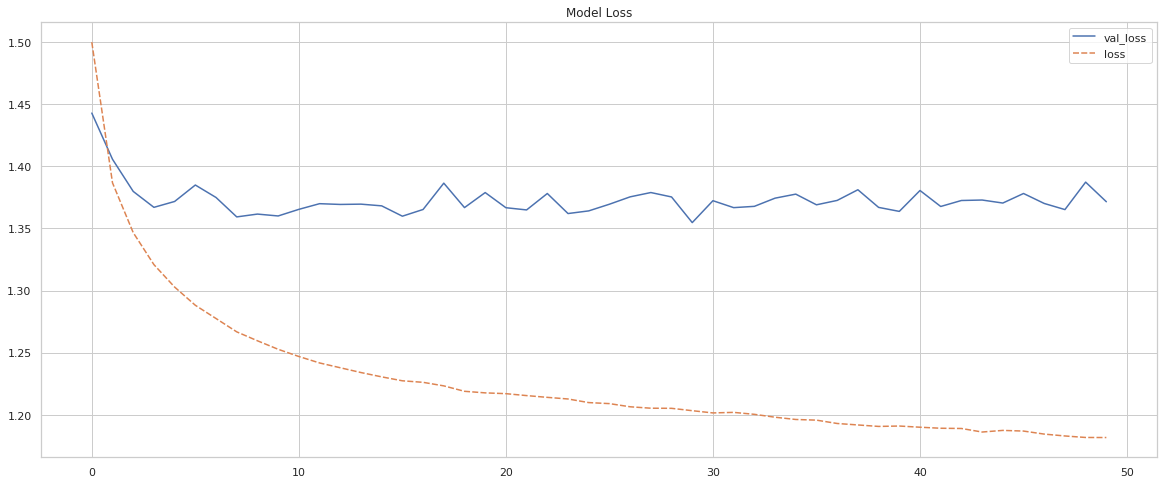

In [16]:
history_pd = pd.DataFrame.from_dict(history.history)
plt.figure(figsize=(20, 8))
ax = plt.axes()
ax.set_title('Model Loss')
sns.lineplot(data=history_pd)
plt.show()

#### Model evaluation

In [17]:
train_pred = model.predict_classes(X_train_series)
val_pred = model.predict_classes(X_val_series)
Y_train_max = np.argmax(Y_train, axis=1)
Y_val_max = np.argmax(Y_val, axis=1)

print('Train accuracy', accuracy_score(Y_train_max, train_pred))
print('Validation accuracy', accuracy_score(Y_val_max, val_pred))

Train accuracy 0.5489710238535379
Validation accuracy 0.507855025003319


#### Model confusion matrix

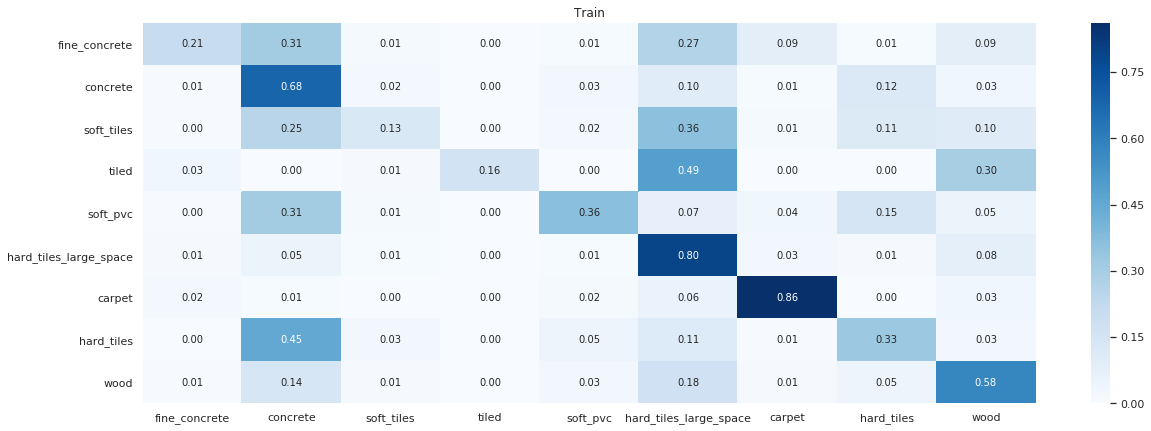

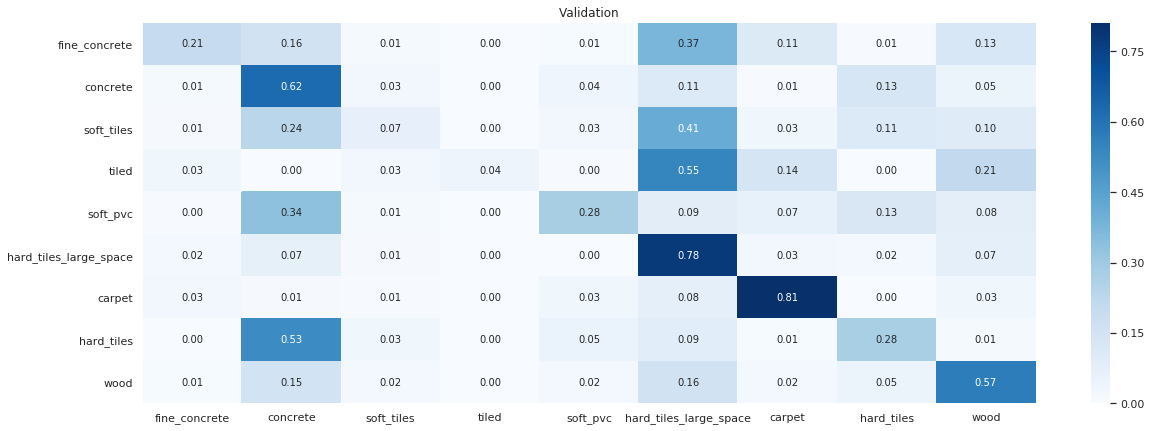

In [18]:
cnf_matrix = confusion_matrix(Y_train_max, train_pred)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels_names, columns=labels_names)

plt.figure(figsize=(20, 7))
ax = plt.axes()
ax.set_title('Train')
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues", ax=ax)
plt.show()

cnf_matrix = confusion_matrix(Y_val_max, val_pred)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels_names, columns=labels_names)

plt.figure(figsize=(20, 7))
ax = plt.axes()
ax.set_title('Validation')
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues", ax=ax)
plt.show()

### Test predictions

In [19]:
predictions = model.predict_classes(X_test_series)
test['surface'] = le.inverse_transform(predictions)
df = test[['series_id', 'surface']]
df = df.groupby('series_id', as_index=False).agg(lambda x:x.value_counts().index[0])
df.to_csv('submission.csv', index=False)
df.head(10)

,series_id,surface
0,0,concrete
1,1,soft_pvc
2,2,concrete
3,3,carpet
4,4,soft_tiles
5,5,concrete
6,6,soft_pvc
7,7,concrete
8,8,wood
9,9,wood
